In [1]:
# 필요 라이브러리 로딩
from __future__ import absolute_import, division
from __future__ import print_function, unicode_literals

import os
import time
import shutil
import functools

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12,12)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.image as mpimg
import pandas as pd
from PIL import Image
from IPython.display import clear_output

import tensorflow as tf
import tensorflow_addons as tfa
print(tf.__version__)

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import models

2.6.0


# STEP 1 : 데이터셋 구성

Giana Dataset 용종 내시경 데이터셋 사용

In [2]:
!mkdir -p ~/aiffel/medical
!ln -s ~/data/* ~/aiffel/medical

ln: failed to create symbolic link '/aiffel/aiffel/medical/ed_ckpt': File exists
ln: failed to create symbolic link '/aiffel/aiffel/medical/train': File exists
ln: failed to create symbolic link '/aiffel/aiffel/medical/train_labels': File exists
ln: failed to create symbolic link '/aiffel/aiffel/medical/unet_ckpt': File exists


In [3]:
DATASET_PATH = os.path.join(os.getenv('HOME'), 'aiffel', 'medical')

img_dir = os.path.join(DATASET_PATH, "train")
label_dir = os.path.join(DATASET_PATH, "train_labels")

x_train_filenames = [os.path.join(img_dir, filename) for filename in os.listdir(img_dir)]
x_train_filenames.sort()
y_train_filenames = [os.path.join(label_dir, filename) for filename in os.listdir(label_dir)]
y_train_filenames.sort()
x_train_filenames, x_test_filenames, y_train_filenames, y_test_filenames = \
                    train_test_split(x_train_filenames, y_train_filenames, test_size=0.2)

num_train_examples = len(x_train_filenames)
num_test_examples = len(x_test_filenames)

print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples: {}".format(num_test_examples))

Number of training examples: 240
Number of test examples: 60


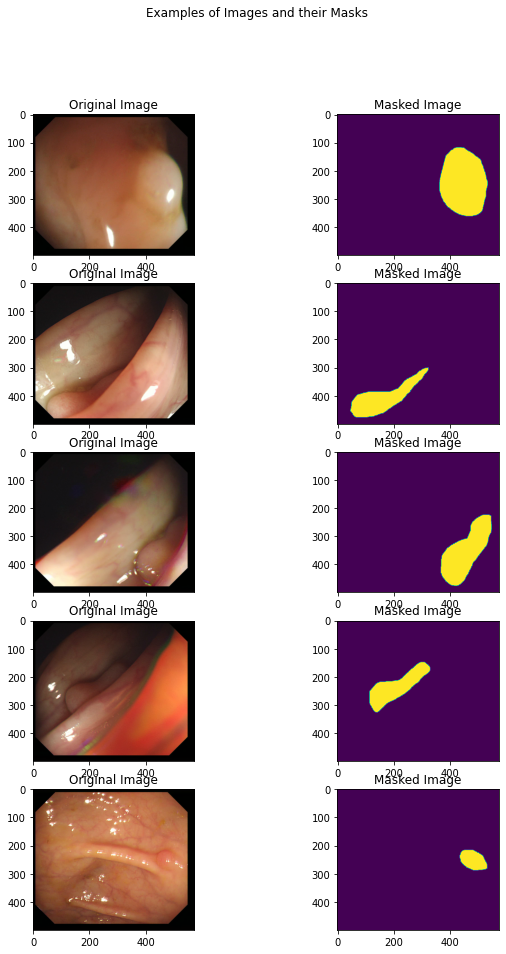

In [4]:
display_num = 5

r_choices = np.random.choice(num_train_examples, display_num)

plt.figure(figsize=(10, 15))
for i in range(0, display_num * 2, 2):
    img_num = r_choices[i // 2]
    x_pathname = x_train_filenames[img_num]
    y_pathname = y_train_filenames[img_num]

    plt.subplot(display_num, 2, i + 1)
    plt.imshow(Image.open(x_pathname))
    plt.title("Original Image")

    example_labels = Image.open(y_pathname)
    label_vals = np.unique(example_labels)

    plt.subplot(display_num, 2, i + 2)
    plt.imshow(example_labels)
    plt.title("Masked Image")
    
plt.suptitle("Examples of Images and their Masks")
plt.show()

# STEP 2 : pretrained model을 활용한 U-Net 모델 구성

Data pipeline and Preprocessing

In [5]:
# Set hyperparameters

image_size = 256
img_shape = (image_size, image_size, 3)
batch_size = 8
max_epochs = 10

In [6]:
# Processing each pathname
def _process_pathnames(fname, label_path):
    # We map this function onto each pathname pair
    img_str = tf.io.read_file(fname)
    img = tf.image.decode_bmp(img_str, channels=3)

    label_img_str = tf.io.read_file(label_path)
    label_img = tf.image.decode_bmp(label_img_str, channels=3)
    label_img = tf.image.rgb_to_grayscale(label_img)

    resize = [image_size, image_size]
    img = tf.image.resize(img, resize)
    label_img = tf.image.resize(label_img, resize)

    scale = 1 / 255.
    img = tf.cast(img, dtype=tf.float32) * scale
    label_img = tf.cast(label_img, dtype=tf.float32) * scale

    return img, label_img

In [7]:
# Data augmentation - Shifting the image
def shift_img(output_img, label_img, width_shift_range, height_shift_range):
    """This fn will perform the horizontal or vertical shift"""
    if width_shift_range or height_shift_range:
        if width_shift_range:
                width_shift_range = tf.random.uniform([],
                                                  -width_shift_range * img_shape[1],
                                                  width_shift_range * img_shape[1])
        if height_shift_range:
                height_shift_range = tf.random.uniform([],
                                                   -height_shift_range * img_shape[0],
                                                   height_shift_range * img_shape[0])
        output_img = tfa.image.translate(output_img,
                                         [width_shift_range, height_shift_range])
        label_img = tfa.image.translate(label_img,
                                        [width_shift_range, height_shift_range])
    return output_img, label_img

In [8]:
# Data augmentation - Flipping the image randomly
def flip_img(horizontal_flip, tr_img, label_img):
    if horizontal_flip:
        flip_prob = tf.random.uniform([], 0.0, 1.0)
        tr_img, label_img = tf.cond(tf.less(flip_prob, 0.5),
                                lambda: (tf.image.flip_left_right(tr_img), tf.image.flip_left_right(label_img)),
                                lambda: (tr_img, label_img))
    return tr_img, label_img

In [9]:
# Data augmentation Assembling
def _augment(img,
             label_img,
             resize=None,  # Resize the image to some size e.g. [256, 256]
             scale=1,  # Scale image e.g. 1 / 255.
             hue_delta=0.,  # Adjust the hue of an RGB image by random factor
             horizontal_flip=True,  # Random left right flip,
             width_shift_range=0.05,  # Randomly translate the image horizontally
             height_shift_range=0.05):  # Randomly translate the image vertically 
    if resize is not None:
        # Resize both images
        label_img = tf.image.resize(label_img, resize)
        img = tf.image.resize(img, resize)
  
    if hue_delta:
        img = tf.image.random_hue(img, hue_delta)
  
    img, label_img = flip_img(horizontal_flip, img, label_img)
    img, label_img = shift_img(img, label_img, width_shift_range, height_shift_range)
    label_img = tf.cast(label_img, dtype=tf.float32) * scale
    img = tf.cast(img, dtype=tf.float32) * scale
    return img, label_img

In [10]:
# Set up train and test datasets
def get_baseline_dataset(filenames,
                         labels,
                         preproc_fn=functools.partial(_augment),
                         threads=4,
                         batch_size=batch_size,
                         is_train=True):
    num_x = len(filenames)
    # Create a dataset from the filenames and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    # Map our preprocessing function to every element in our dataset, taking
    # advantage of multithreading
    dataset = dataset.map(_process_pathnames, num_parallel_calls=threads)

    if is_train:# 학습을 진행할시에만 위에 augment를 진행합니다.
        #if preproc_fn.keywords is not None and 'resize' not in preproc_fn.keywords:
        #  assert batch_size == 1, "Batching images must be of the same size"
        dataset = dataset.map(preproc_fn, num_parallel_calls=threads)
        dataset = dataset.shuffle(num_x * 10)

    dataset = dataset.batch(batch_size)
    return dataset

In [11]:
train_dataset = get_baseline_dataset(x_train_filenames, # 학습 데이터
                                     y_train_filenames) # 정답 데이터
train_dataset = train_dataset.repeat()
test_dataset = get_baseline_dataset(x_test_filenames,
                                    y_test_filenames,
                                    is_train=False)
train_dataset

<RepeatDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 1)), types: (tf.float32, tf.float32)>

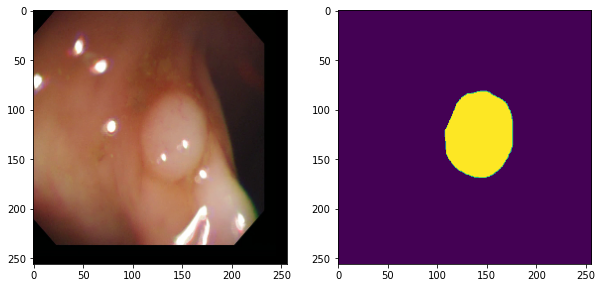

In [12]:
for images, labels in train_dataset.take(1):
    # Running next element in our graph will produce a batch of images
    plt.figure(figsize=(10, 10))
    img = images[0]

    plt.subplot(1, 2, 1)
    plt.imshow(img)

    plt.subplot(1, 2, 2)
    plt.imshow(labels[0, :, :, 0])
    plt.show()

# STEP 2 : 모델 구성

### 2.1 Encoder-Decoder 모델

In [13]:
# inputs: [batch_size, 256, 256, 3]
encoder = tf.keras.Sequential(name='encoder')

# conv-batchnorm-activation-maxpool
encoder.add(layers.Conv2D(64, (3, 3), padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))
encoder.add(layers.Conv2D(64, (3, 3), strides=2, padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu')) # conv1: [batch_size, 128, 128, 64]

encoder.add(layers.Conv2D(128, (3, 3), padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))
encoder.add(layers.Conv2D(128, (3, 3), strides=2, padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu')) # conv2: [batch_size, 64, 64, 128]

encoder.add(layers.Conv2D(256, (3, 3), padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))
encoder.add(layers.Conv2D(256, (3, 3), strides=2, padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu')) # conv3: [batch_size, 32, 32, 256]

encoder.add(layers.Conv2D(512, (3, 3), padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))
encoder.add(layers.Conv2D(512, (3, 3), strides=2, padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu')) # conv4-outputs: [batch_size, 16, 16, 512]

In [14]:
# inputs: [batch_size, 16, 16, 512]
decoder = tf.keras.Sequential(name='decoder')

# conv_transpose-batchnorm-activation
decoder.add(layers.Conv2DTranspose(256, (3, 3), strides=2, padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu')) # conv_transpose1: [batch_size, 32, 32, 256]
decoder.add(layers.Conv2D(256, (3, 3), padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))

decoder.add(layers.Conv2DTranspose(128, (3, 3), strides=2, padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu')) # conv_transpose2: [batch_size, 64, 64, 128]
decoder.add(layers.Conv2D(128, (3, 3), padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))

decoder.add(layers.Conv2DTranspose(64, (3, 3), strides=2, padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu')) # conv_transpose3: [batch_size, 128, 128, 64]
decoder.add(layers.Conv2D(64, (3, 3), padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))

decoder.add(layers.Conv2DTranspose(32, (3, 3), strides=2, padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu')) # conv transpose4-outputs: [batch_size, 256, 256, 32]
decoder.add(layers.Conv2D(32, (3, 3), padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))

decoder.add(layers.Conv2DTranspose(1, 1, strides=1, padding='same', activation='sigmoid'))

In [15]:
# Encoder 제대로 만들어졌는지 확인

bottleneck = encoder(tf.random.normal([batch_size, 256, 256, 3]))
print(bottleneck.shape)   # (batch_size, 16, 16, 512) 이 나오는지 확인

(8, 16, 16, 512)


In [16]:
# decoder 제대로 만들어졌는지 확인

predictions = decoder(bottleneck)
print(predictions.shape)    # (batch_size, 256, 256, 1) 이 나오는지 확인

(8, 256, 256, 1)


In [17]:
ed_model = tf.keras.Sequential()

ed_model.add(encoder)
ed_model.add(decoder)

### 2.2 U-Net 모델

In [18]:
class Conv(tf.keras.Model):
    def __init__(self, num_filters, kernel_size):
        super(Conv, self).__init__()
        self.conv = layers.Conv2D(num_filters, kernel_size, padding='same')
        self.bn = layers.BatchNormalization()

    def call(self, inputs, training=True):
        x = self.conv(inputs)
        x = self.bn(x, training=training)
        x = layers.ReLU()(x)

        return x

In [19]:
class ConvBlock(tf.keras.Model):
    def __init__(self, num_filters):
        super(ConvBlock, self).__init__()
        self.conv1 = Conv(num_filters, 3)
        self.conv2 = Conv(num_filters * 2, 3)

    def call(self, inputs, training=True):
        encoder = self.conv1(inputs, training=training)
        encoder = self.conv2(encoder, training=training)

        return encoder

class ConvBlock_R(tf.keras.Model):
    def __init__(self, num_filters):
        super(ConvBlock_R, self).__init__()
        self.conv1 = Conv(num_filters, 3)
        self.conv2 = Conv(num_filters, 3)

    def call(self, inputs, training=True):
        decoder = self.conv1(inputs, training=training)
        decoder = self.conv2(decoder, training=training)

        return decoder


class EncoderBlock(tf.keras.Model):
    def __init__(self, num_filters):
        super(EncoderBlock, self).__init__()
        self.conv_block = ConvBlock(num_filters)
        self.encoder_pool = layers.MaxPool2D()

    def call(self, inputs, training=True):
        encoder = self.conv_block(inputs, training=training)
        encoder_pool = self.encoder_pool(encoder)

        return encoder_pool, encoder


class DecoderBlock(tf.keras.Model):
    def __init__(self, num_filters):
        super(DecoderBlock, self).__init__()
        self.convT = layers.Conv2DTranspose(num_filters, 3, strides=2, padding='same')
        self.bn = layers.BatchNormalization()
        self.conv_block_r = ConvBlock_R(num_filters)

    def call(self, input_tensor, concat_tensor, training=True):
        decoder = self.convT(input_tensor)            
        decoder = self.bn(decoder, training=training)
        decoder = layers.ReLU()(decoder)
        decoder = tf.concat([decoder, concat_tensor], axis=-1)
        decoder = self.conv_block_r(decoder, training=training)

        return decoder

In [20]:
class UNet(tf.keras.Model):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder_block1 = EncoderBlock(64)
        self.encoder_block2 = EncoderBlock(128)
        self.encoder_block3 = EncoderBlock(256)
        self.encoder_block4 = EncoderBlock(512)

        self.center = ConvBlock(1024)

        self.decoder_block4 = DecoderBlock(512)
        self.decoder_block3 = DecoderBlock(256)
        self.decoder_block2 = DecoderBlock(128)
        self.decoder_block1 = DecoderBlock(64)

        self.output_conv = layers.Conv2D(1, 1, activation='sigmoid')

    def call(self, inputs, training=True):
        encoder1_pool, encoder1 = self.encoder_block1(inputs)
        encoder2_pool, encoder2 = self.encoder_block2(encoder1_pool)
        encoder3_pool, encoder3 = self.encoder_block3(encoder2_pool)
        encoder4_pool, encoder4 = self.encoder_block4(encoder3_pool)

        center = self.center(encoder4_pool)

        decoder4 = self.decoder_block4(center, encoder4)
        decoder3 = self.decoder_block3(decoder4, encoder3)
        decoder2 = self.decoder_block2(decoder3, encoder2)
        decoder1 = self.decoder_block1(decoder2, encoder1)

        outputs = self.output_conv(decoder1)

        return outputs

In [21]:
unet_model = UNet()

In [22]:
def dice_coeff(y_true, y_pred):
    smooth = 1e-10
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(tf.square(y_true_f)) + \
                                            tf.reduce_sum(tf.square(y_pred_f)) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = tf.reduce_mean(losses.binary_crossentropy(y_true, y_pred)) + \
          dice_loss(y_true, y_pred)
    return loss

optimizer = tf.keras.optimizers.Adam() # 기본 Learning rate 사용

### 2.3 VGG16을 사용한 U-Net 모델

In [23]:
import tensorflow as tf

def build_vgg_unet(input_shape):
    # VGG16의 base model을 불러옵니다.
    base_model = tf.keras.applications.VGG16(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False  # Encoder 부분 고정
    
    # Encoder
    inputs = base_model.input
    x = base_model.output
    
    # Decoder
    x = tf.keras.layers.Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)
    
    # 최종 출력 층
    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(x)  # 세그멘테이션 결과 (1 채널)

    return tf.keras.Model(inputs, outputs)

# 이미지 크기 설정: (128, 128, 3)
img_shape = (128, 128, 3)

# 모델 빌드 및 컴파일
vgg_unet_model = build_vgg_unet(img_shape)
vgg_unet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
vgg_unet_model.summary()

# 배치 크기 설정
batch_size = 2 # 배치 크기 줄이기


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

In [24]:
def dice_coeff(y_true, y_pred):
    smooth = 1e-10
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(tf.square(y_true_f)) + \
                                            tf.reduce_sum(tf.square(y_pred_f)) + smooth)

    return score

In [25]:
def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

In [26]:
# 체크포인트를 저장할 디렉토리 경로 설정
checkpoint_dir = './checkpoints'  # 원하는 경로로 수정 가능

# 체크포인트 디렉토리가 없으면 생성
if not os.path.isdir(checkpoint_dir):
    os.makedirs(checkpoint_dir)

# ModelCheckpoint 콜백 정의
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_dir,                      # 저장 경로
    save_weights_only=True,               # 가중치만 저장
    monitor='val_loss',                   # 성능을 모니터링할 지표
    mode='auto',                          # 모니터링 지표에 따른 자동 설정
    save_best_only=True,                  # 가장 좋은 모델만 저장
    verbose=0
)

In [27]:
cos_decay = tf.keras.experimental.CosineDecay(1e-3, 
                                              max_epochs)
lr_callback = tf.keras.callbacks.LearningRateScheduler(cos_decay, verbose=1)

# STEP 3 : 학습과 테스트, 시각화

#### 3-1 encoder_decoder_model을 학습

In [28]:
# 모델 컴파일
ed_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                 loss='binary_crossentropy',   # 이진 분류 문제일 경우
                 metrics=['accuracy'])         # accuracy를 평가 지표로 사용

In [29]:
import os
from PIL import Image

for filename in y_train_filenames:
    try:
        img = Image.open(filename)
        print(f"{filename}: {img.mode}")
    except Exception as e:
        print(f"Error in {filename}: {e}")


/aiffel/aiffel/medical/train_labels/97.bmp: L
/aiffel/aiffel/medical/train_labels/133.bmp: L
/aiffel/aiffel/medical/train_labels/35.bmp: L
/aiffel/aiffel/medical/train_labels/117.bmp: L
/aiffel/aiffel/medical/train_labels/89.bmp: L
/aiffel/aiffel/medical/train_labels/171.bmp: L
/aiffel/aiffel/medical/train_labels/37.bmp: L
/aiffel/aiffel/medical/train_labels/77.bmp: L
/aiffel/aiffel/medical/train_labels/139.bmp: L
/aiffel/aiffel/medical/train_labels/222.bmp: L
/aiffel/aiffel/medical/train_labels/21.bmp: L
/aiffel/aiffel/medical/train_labels/57.bmp: L
/aiffel/aiffel/medical/train_labels/141.bmp: L
/aiffel/aiffel/medical/train_labels/105.bmp: L
/aiffel/aiffel/medical/train_labels/219.bmp: L
/aiffel/aiffel/medical/train_labels/195.bmp: L
/aiffel/aiffel/medical/train_labels/292.bmp: L
/aiffel/aiffel/medical/train_labels/183.bmp: L
/aiffel/aiffel/medical/train_labels/231.bmp: L
/aiffel/aiffel/medical/train_labels/70.bmp: L
/aiffel/aiffel/medical/train_labels/178.bmp: L
/aiffel/aiffel/medica

In [30]:
import tensorflow as tf
import os
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from PIL import Image
import numpy as np

# 데이터셋 로드 및 전처리 함수
def parse_image(filename, label_filename):
    # 이미지 읽기 (BMP 처리)
    image = tf.io.read_file(filename)
    image = tf.image.decode_bmp(image)  # BMP 포맷 디코딩
    image = tf.image.resize(image, [256, 256])  # 크기 조정
    image = tf.cast(image, tf.float32) / 255.0  # 정규화

    # 라벨 읽기 (BMP 처리)
    label = tf.io.read_file(label_filename)
    label = tf.image.decode_bmp(label)  # BMP 포맷 디코딩
    label = tf.image.resize(label, [256, 256])
    label = tf.cast(label, tf.float32) / 255.0  # 정규화
    label = label[..., tf.newaxis]  # 채널 차원 추가

    return image, label


# 데이터셋 생성 함수
def create_dataset(image_filenames, label_filenames, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((image_filenames, label_filenames))
    dataset = dataset.map(lambda x, y: parse_image(x, y), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size=1000)  # 데이터 섞기
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset


# 데이터 경로 설정
DATASET_PATH = os.path.join(os.getenv('HOME'), 'aiffel', 'medical')

img_dir = os.path.join(DATASET_PATH, "train")
label_dir = os.path.join(DATASET_PATH, "train_labels")

x_train_filenames = [os.path.join(img_dir, filename) for filename in os.listdir(img_dir) if filename.endswith('.bmp')]
x_train_filenames.sort()
y_train_filenames = [os.path.join(label_dir, filename) for filename in os.listdir(label_dir) if filename.endswith('.bmp')]
y_train_filenames.sort()

# 데이터셋 분리
x_train_filenames, x_test_filenames, y_train_filenames, y_test_filenames = train_test_split(
    x_train_filenames, y_train_filenames, test_size=0.2, random_state=42)

num_train_examples = len(x_train_filenames)
num_test_examples = len(x_test_filenames)

# 데이터셋 생성
batch_size = 8
train_dataset = create_dataset(x_train_filenames, y_train_filenames, batch_size)
test_dataset = create_dataset(x_test_filenames, y_test_filenames, batch_size)

# 모델 학습
max_epochs = 10
history = ed_model.fit(
    train_dataset,
    epochs=max_epochs,
    steps_per_epoch=num_train_examples // batch_size,
    validation_data=test_dataset,
    validation_steps=num_test_examples // batch_size
)

# 모델 평가
loss, accuracy = ed_model.evaluate(test_dataset)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")


Epoch 1/10
30/30 [==============================] - 11s 215ms/step - loss: 0.4378 - accuracy: 0.8746 - val_loss: 0.5952 - val_accuracy: 0.9498
Epoch 2/10
30/30 [==============================] - 7s 205ms/step - loss: 0.2546 - accuracy: 0.9471 - val_loss: 0.5221 - val_accuracy: 0.9510
Epoch 3/10
30/30 [==============================] - 7s 208ms/step - loss: 0.2172 - accuracy: 0.9475 - val_loss: 0.4082 - val_accuracy: 0.9508
Epoch 4/10
30/30 [==============================] - 7s 209ms/step - loss: 0.2014 - accuracy: 0.9475 - val_loss: 0.3113 - val_accuracy: 0.9484
Epoch 5/10
30/30 [==============================] - 7s 211ms/step - loss: 0.1929 - accuracy: 0.9475 - val_loss: 0.3897 - val_accuracy: 0.9224
Epoch 6/10
30/30 [==============================] - 7s 210ms/step - loss: 0.1845 - accuracy: 0.9475 - val_loss: 0.2232 - val_accuracy: 0.9493
Epoch 7/10
30/30 [==============================] - 7s 208ms/step - loss: 0.1799 - accuracy: 0.9475 - val_loss: 0.2295 - val_accuracy: 0.9491
Epoch

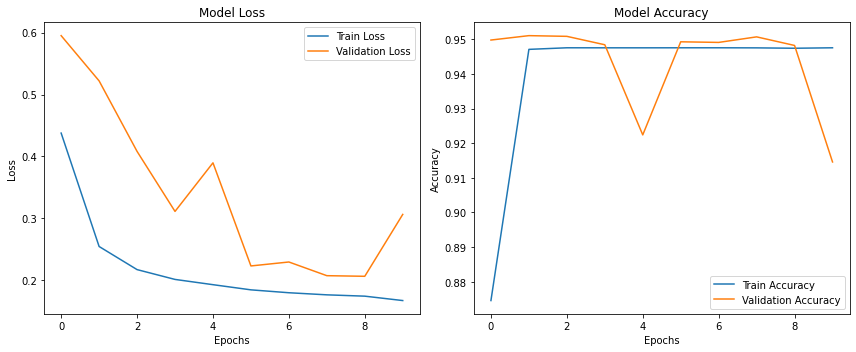

In [31]:
import matplotlib.pyplot as plt

# 학습 히스토리 시각화 함수
def plot_history(history):
    # 손실(Loss) 그래프
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # 정확도(Accuracy) 그래프
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# 히스토리 시각화
plot_history(history)


#### 3-2 U-Net 모델을 학습

In [32]:
print('select the U-Net model')
model = unet_model
checkpoint_dir =os.path.join(DATASET_PATH,'train_ckpt/unet_model')

select the U-Net model


In [33]:
model.compile(optimizer=optimizer, loss=bce_dice_loss, metrics=[dice_loss])
predictions = model(tf.random.normal([batch_size, image_size, image_size, 3]))
print(predictions.shape)

(8, 256, 256, 1)


In [34]:
if not os.path.isdir(checkpoint_dir):
    os.makedirs(checkpoint_dir)

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=0)
cos_decay = tf.keras.experimental.CosineDecay(1e-3, 
                                              max_epochs)
lr_callback = tf.keras.callbacks.LearningRateScheduler(cos_decay, verbose=1)

In [35]:
## Define print function
def print_images():
    for test_images, test_labels in test_dataset.take(1):
        predictions = model(test_images, training=False)

        plt.figure(figsize=(10, 20))
        plt.subplot(1, 3, 1)
        plt.imshow(test_images[0,: , :, :])
        plt.title("Input image")

        plt.subplot(1, 3, 2)
        plt.imshow(test_labels[0, :, :, 0])
        plt.title("Actual Mask")

        plt.subplot(1, 3, 3)
        plt.imshow(predictions[0, :, :, 0])
        plt.title("Predicted Mask")
        plt.show()

In [36]:
history = model.fit(train_dataset,
                    epochs=max_epochs,    # 10
                    steps_per_epoch=num_train_examples//batch_size,
                    validation_data=test_dataset,
                    validation_steps=num_test_examples//batch_size,
                    callbacks=[cp_callback, lr_callback]
                    )

Epoch 1/10

Epoch 00001: LearningRateScheduler setting learning rate to tf.Tensor(0.001, shape=(), dtype=float32).
30/30 [==============================] - 38s 916ms/step - loss: 1.1093 - dice_loss: 0.7316 - val_loss: 15956.4707 - val_dice_loss: 0.9027
Epoch 2/10

Epoch 00002: LearningRateScheduler setting learning rate to tf.Tensor(0.00097552827, shape=(), dtype=float32).
30/30 [==============================] - 27s 895ms/step - loss: 0.9250 - dice_loss: 0.6935 - val_loss: 1.9579 - val_dice_loss: 0.8694
Epoch 3/10

Epoch 00003: LearningRateScheduler setting learning rate to tf.Tensor(0.0009045085, shape=(), dtype=float32).
30/30 [==============================] - 27s 900ms/step - loss: 0.9156 - dice_loss: 0.7002 - val_loss: 1.0405 - val_dice_loss: 0.7755
Epoch 4/10

Epoch 00004: LearningRateScheduler setting learning rate to tf.Tensor(0.00079389266, shape=(), dtype=float32).
30/30 [==============================] - 27s 895ms/step - loss: 0.8899 - dice_loss: 0.6828 - val_loss: 0.9996 -

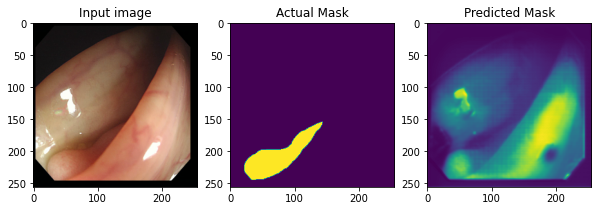

In [37]:
# print sample image after training
print_images()

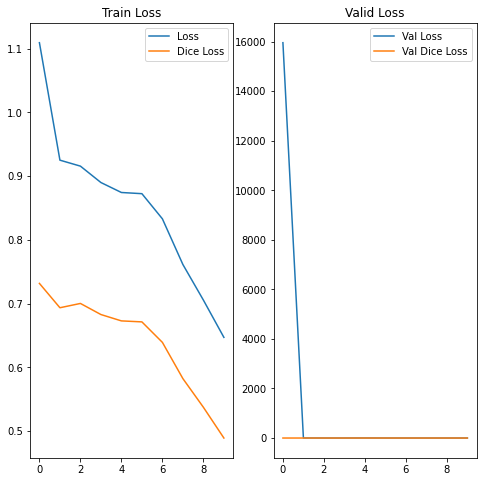

In [38]:
dice_loss = history.history['dice_loss']
loss = history.history['loss']
val_dice_loss = history.history['val_dice_loss']
val_loss = history.history['val_loss']

epochs_range = range(max_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='Loss')
plt.plot(epochs_range, dice_loss, label='Dice Loss')
plt.legend(loc='upper right')
plt.title('Train Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.plot(epochs_range, val_dice_loss, label='Val Dice Loss')
plt.legend(loc='upper right')
plt.title('Valid Loss')
plt.show()

#### 3-3 VGG16을 사용한 U-Net 모델을 학습

In [39]:
# 모델 컴파일
vgg_unet_model.compile(optimizer='adam', loss=dice_loss, metrics=[dice_coeff])

In [41]:
for image, label in train_dataset.take(1):
    print(f"Image shape: {image.shape}, Label shape: {label.shape}")

Image shape: (8, 256, 256, 3), Label shape: (8, 256, 256, 1, 1)


In [42]:
def build_vgg_unet(input_shape):
    base_model = tf.keras.applications.VGG16(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False  # Encoder 부분 고정
    
    inputs = base_model.input
    x = base_model.output

    # Decoder 부분 - 업샘플링을 통해 이미지 크기를 확장
    x = tf.keras.layers.Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)  # 4 -> 8
    x = tf.keras.layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)  # 8 -> 16
    x = tf.keras.layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)  # 16 -> 32
    x = tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)   # 32 -> 64
    x = tf.keras.layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)   # 64 -> 128
    x = tf.keras.layers.Conv2DTranspose(16, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)   # 128 -> 256
    x = tf.keras.layers.Conv2DTranspose(8, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)    # 256 -> 512

    # 최종 출력 층
    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(x)  # 세그멘테이션 결과 (1 채널)

    return tf.keras.Model(inputs, outputs)


In [43]:
output = vgg_unet_model.output
print(output.shape)  # (None, 128, 128, 1)이어야 합니다.


(None, 64, 64, 1)


In [44]:
for images, labels in train_dataset.take(1):  # 하나의 배치를 확인
    print(f"Image shape: {images.shape}")
    print(f"Label shape: {labels.shape}")


Image shape: (8, 256, 256, 3)
Label shape: (8, 256, 256, 1, 1)


In [45]:
import os
import tensorflow as tf

# 데이터셋 경로 설정
DATASET_PATH = os.path.join(os.getenv('HOME'), 'aiffel', 'medical')
img_dir = os.path.join(DATASET_PATH, "train")
label_dir = os.path.join(DATASET_PATH, "train_labels")

# 이미지 파일 및 라벨 파일 경로 설정
x_train_filenames = [os.path.join(img_dir, filename) for filename in os.listdir(img_dir) if filename.endswith('.bmp')]
x_train_filenames.sort()
y_train_filenames = [os.path.join(label_dir, filename) for filename in os.listdir(label_dir) if filename.endswith('.bmp')]
y_train_filenames.sort()

def parse_image(filename, label_filename):
    # 이미지 읽기 (BMP 처리)
    image = tf.io.read_file(filename)
    image = tf.image.decode_bmp(image)
    image = tf.image.resize(image, [128, 128])
    image = tf.cast(image, tf.float32) / 255.0

    # 라벨 읽기 (BMP 처리)
    label = tf.io.read_file(label_filename)
    label = tf.image.decode_bmp(label)
    label = tf.image.resize(label, [128, 128])
    label = tf.cast(label, tf.float32) / 255.0

    # 라벨의 불필요한 차원 제거
    label = tf.squeeze(label, axis=-1)  # (128, 128, 1) -> (128, 128)

    # 모델에 맞게 채널 차원 추가
    label = tf.expand_dims(label, axis=-1)  # (128, 128) -> (128, 128, 1)로 변경

    return image, label



# 데이터셋 생성 함수
def create_dataset(image_filenames, label_filenames, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((image_filenames, label_filenames))
    dataset = dataset.map(lambda x, y: parse_image(x, y), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size=1000)  # 데이터 섞기
    dataset = dataset.batch(batch_size)  # 배치 크기 설정
    dataset = dataset.prefetch(tf.data.AUTOTUNE)  # 데이터 미리 가져오기
    return dataset

# 배치 크기 설정
batch_size = 4

# 학습 데이터셋 생성
train_dataset = create_dataset(x_train_filenames, y_train_filenames, batch_size)

# 검증 데이터셋 생성 (검증 이미지/라벨 경로 필요)
val_image_filenames = x_train_filenames  # 같은 방식으로 검증 데이터 경로 설정
val_label_filenames = y_train_filenames

# 검증 데이터셋 생성
val_dataset = create_dataset(val_image_filenames, val_label_filenames, batch_size)

# VGG U-Net 모델 빌드 함수
def build_vgg_unet(input_shape):
    base_model = tf.keras.applications.VGG16(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False  # Encoder 부분 고정
    
    inputs = base_model.input
    x = base_model.output

    # Decoder 부분
    x = tf.keras.layers.Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)
    
    # 최종 출력 층
    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(x)  # 세그멘테이션 결과 (1 채널)

    return tf.keras.Model(inputs, outputs)

# Dice Loss 정의
def dice_coeff(y_true, y_pred):
    smooth = 1e-10
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(tf.square(y_true_f)) + tf.reduce_sum(tf.square(y_pred_f)) + smooth)
    return score

def dice_loss(y_true, y_pred):
    # y_true와 y_pred 모두 (batch_size, height, width, 1) 형태이어야 함
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])

    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + 1e-10) / (tf.reduce_sum(tf.square(y_true_f)) + tf.reduce_sum(tf.square(y_pred_f)) + 1e-10)
    
    return 1 - score  # Dice Loss는 1 - Dice coefficient



# 모델 빌드
img_shape = (128, 128, 3)
vgg_unet_model = build_vgg_unet(img_shape)

# 체크포인트를 저장할 디렉토리 경로 설정
checkpoint_dir = './checkpoints'

# 체크포인트 디렉토리가 없으면 생성
if not os.path.isdir(checkpoint_dir):
    os.makedirs(checkpoint_dir)

# ModelCheckpoint 콜백 정의
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_dir,                      # 저장 경로
    save_weights_only=True,               # 가중치만 저장
    monitor='val_loss',                   # 성능을 모니터링할 지표
    mode='auto',                          # 모니터링 지표에 따른 자동 설정
    save_best_only=True,                  # 가장 좋은 모델만 저장
    verbose=1
)

# CosineDecay 학습률 스케줄러
max_epochs = 50  # 최대 에폭 수 설정
cos_decay = tf.keras.optimizers.schedules.CosineDecay(initial_learning_rate=1e-3, decay_steps=max_epochs)
lr_callback = tf.keras.callbacks.LearningRateScheduler(cos_decay, verbose=1)

# 모델 컴파일
vgg_unet_model.compile(optimizer='adam', loss=dice_loss, metrics=[dice_coeff])

# 모델 학습
history = vgg_unet_model.fit(
    train_dataset,
    epochs=max_epochs,
    validation_data=val_dataset,
    callbacks=[cp_callback, lr_callback]
)

# 학습 완료 후, 최종 모델 저장
vgg_unet_model.save('./final_model.h5')


Epoch 1/50

Epoch 00001: LearningRateScheduler setting learning rate to tf.Tensor(0.001, shape=(), dtype=float32).


InvalidArgumentError:  required broadcastable shapes
	 [[node dice_loss/mul (defined at tmp/ipykernel_1729/1477847844.py:97) ]] [Op:__inference_train_function_26083]

Errors may have originated from an input operation.
Input Source operations connected to node dice_loss/mul:
 dice_loss/Reshape (defined at tmp/ipykernel_1729/1477847844.py:94)	
 dice_loss/Reshape_1 (defined at tmp/ipykernel_1729/1477847844.py:95)

Function call stack:
train_function


# STEP 4 : 모델 성능 비교분석

In [57]:
# U-Net 모델 컴파일 (정확도 추가)
unet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# ED 모델 컴파일 (정확도 추가)
ed_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# U-Net 모델 학습
history_unet = unet_model.fit(
    train_dataset, 
    epochs=10, 
    validation_data=val_dataset
)

# ED 모델 학습
history_ed = ed_model.fit(
    train_dataset, 
    epochs=10, 
    validation_data=val_dataset
)


Epoch 1/10
75/75 [==============================] - 18s 212ms/step - loss: 0.1662 - accuracy: 0.9476 - val_loss: 0.2266 - val_accuracy: 0.9460
Epoch 2/10
75/75 [==============================] - 16s 209ms/step - loss: 0.1569 - accuracy: 0.9477 - val_loss: 0.5701 - val_accuracy: 0.9479
Epoch 3/10
75/75 [==============================] - 16s 214ms/step - loss: 0.1502 - accuracy: 0.9476 - val_loss: 0.7867 - val_accuracy: 0.9479
Epoch 4/10
75/75 [==============================] - 16s 214ms/step - loss: 0.1428 - accuracy: 0.9479 - val_loss: 0.5252 - val_accuracy: 0.9479
Epoch 5/10
75/75 [==============================] - 16s 211ms/step - loss: 0.1386 - accuracy: 0.9480 - val_loss: 0.1944 - val_accuracy: 0.9166
Epoch 6/10
75/75 [==============================] - 16s 210ms/step - loss: 0.1300 - accuracy: 0.9490 - val_loss: 0.1823 - val_accuracy: 0.8970
Epoch 7/10
75/75 [==============================] - 16s 211ms/step - loss: 0.1204 - accuracy: 0.9514 - val_loss: 0.2350 - val_accuracy: 0.9022

1. 모델의 학습 결과

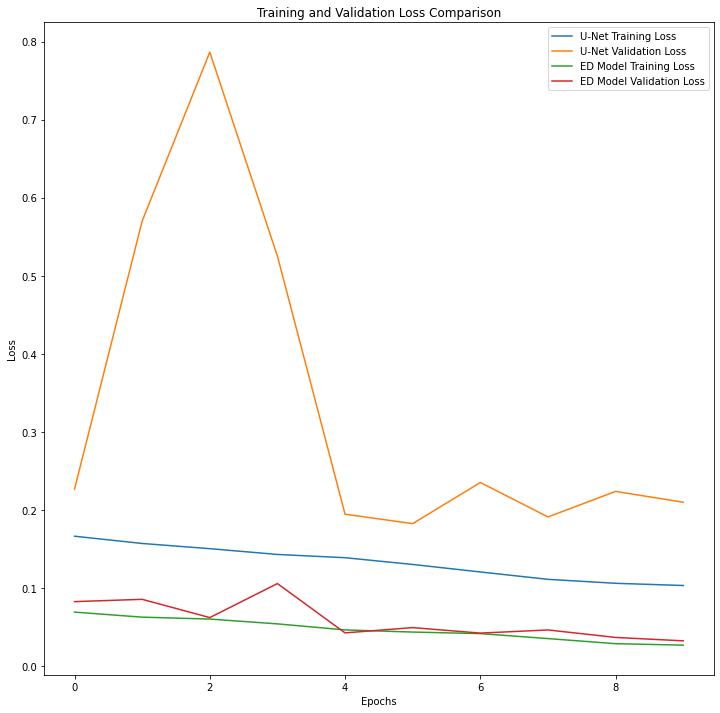

In [58]:
# U-Net 모델의 학습 결과 (history_unet)
plt.plot(history_unet.history['loss'], label='U-Net Training Loss')
plt.plot(history_unet.history['val_loss'], label='U-Net Validation Loss')

# ED 모델의 학습 결과 (history_ed)
plt.plot(history_ed.history['loss'], label='ED Model Training Loss')
plt.plot(history_ed.history['val_loss'], label='ED Model Validation Loss')

plt.title('Training and Validation Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


2. MeanIoU (Intersection over Union) 계산 및 비교

In [59]:
# U-Net 모델의 MeanIoU 평가
mean_iou_unet = unet_model.evaluate(test_dataset)
print(f"U-Net MeanIoU: {mean_iou_unet}")

# ED 모델의 MeanIoU 평가
mean_iou_ed = ed_model.evaluate(test_dataset)
print(f"ED Model MeanIoU: {mean_iou_ed}")



8/8 [==============================] - 3s 263ms/step - loss: 0.2155 - accuracy: 0.9493
U-Net MeanIoU: [0.21554970741271973, 0.9492512941360474]
8/8 [==============================] - 1s 55ms/step - loss: 0.2192 - accuracy: 0.9518
ED Model MeanIoU: [0.21918442845344543, 0.9518330693244934]


3. Segmentation 결과 시각화 (정성적 비교)

label shape: (8, 256, 256, 1, 1)
label_squeezed shape: (256, 256)
Resized label shape: (256, 256, 1)
label shape: (8, 256, 256, 1, 1)
label_squeezed shape: (256, 256)
Resized label shape: (256, 256, 1)
label shape: (8, 256, 256, 1, 1)
label_squeezed shape: (256, 256)
Resized label shape: (256, 256, 1)
label shape: (8, 256, 256, 1, 1)
label_squeezed shape: (256, 256)
Resized label shape: (256, 256, 1)
label shape: (8, 256, 256, 1, 1)
label_squeezed shape: (256, 256)
Resized label shape: (256, 256, 1)


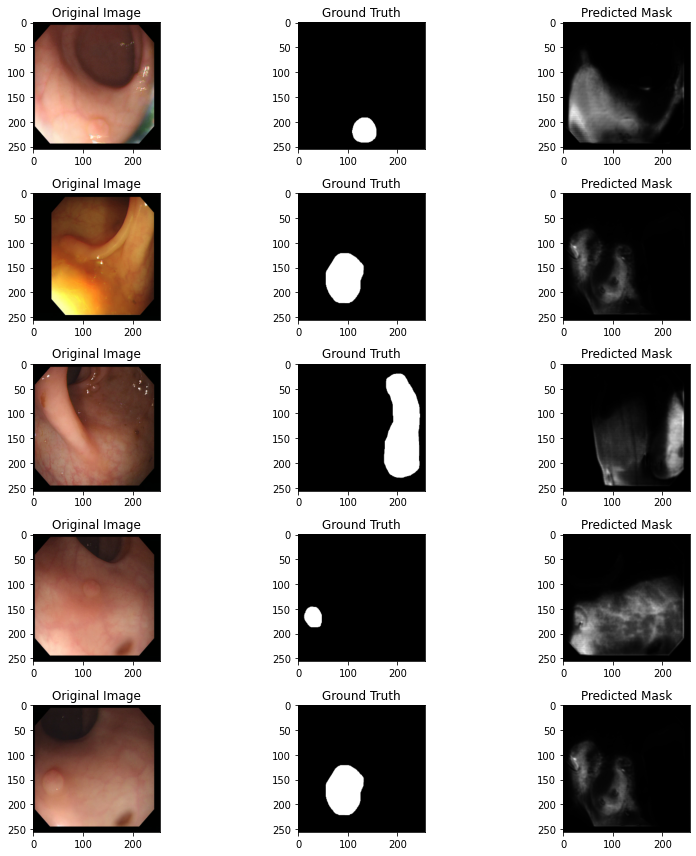

In [77]:
import tensorflow as tf
import matplotlib.pyplot as plt

# U-Net 모델 예측 결과 시각화
plt.figure(figsize=(12, 12))
for i in range(5):  # 예시로 5개의 이미지를 시각화
    image, label = next(iter(test_dataset))  # 테스트 데이터에서 하나의 배치 추출
    prediction = unet_model.predict(image)

    # 원본 이미지, 실제 레이블, 예측 결과 시각화
    plt.subplot(5, 3, i * 3 + 1)
    plt.imshow(image[0])  # 첫 번째 이미지
    plt.title('Original Image')

    # label의 정확한 형태 출력 (디버깅용)
    print(f"label shape: {label.shape}")  # label의 형태를 확인

    # 배치 차원 및 불필요한 차원 제거 (배치 차원 제거 후, (256, 256, 1) 형태로 만듬)
    label_squeezed = tf.squeeze(label[i])  # 배치 차원 제거
    print(f"label_squeezed shape: {label_squeezed.shape}")  # squeezed된 label의 형태를 확인

    # 채널 차원 추가 (리사이즈를 위한 3차원 텐서로 변환)
    label_squeezed = tf.expand_dims(label_squeezed, axis=-1)  # (256, 256, 1)

    # 리사이즈된 label의 크기 확인 (디버깅용)
    label_resized = tf.image.resize(label_squeezed, (256, 256))  # 리사이즈
    
    # 리사이즈된 label의 크기 확인 (디버깅용)
    print(f"Resized label shape: {label_resized.shape}")  # 리사이즈 후 label의 형태를 확인

    # 리사이즈된 label을 2D로 시각화
    plt.subplot(5, 3, i * 3 + 2)
    plt.imshow(label_resized.numpy().squeeze(), cmap='gray')  # 리사이즈된 실제 레이블
    plt.title('Ground Truth')

    # 예측 결과 크기를 (256, 256)으로 리사이즈
    prediction_resized = tf.image.resize(prediction[i], (256, 256))

    plt.subplot(5, 3, i * 3 + 3)
    plt.imshow(prediction_resized.numpy().squeeze(), cmap='gray')  # 리사이즈된 예측 결과
    plt.title('Predicted Mask')

plt.tight_layout()
plt.show()


4. Confusion Matrix (혼동 행렬)

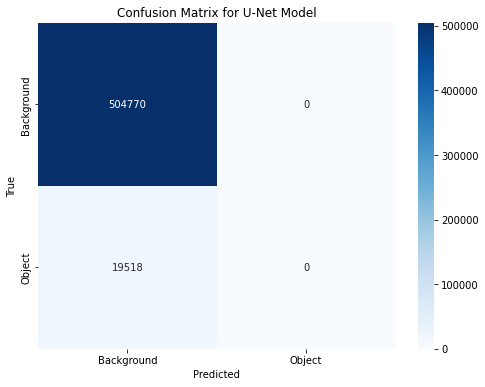

In [81]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# U-Net 모델 예측 결과
y_true = []  # 실제 레이블
y_pred = []  # 모델 예측값

for image, label in test_dataset.take(1):  # 한 배치만 가져와서 예시로 사용
    prediction = unet_model.predict(image)
    
    # 예측값을 이진화 (0과 1로 변환)
    prediction_bin = (prediction > 0.5).astype(int)  # 확률이 0.5 이상이면 객체로 분류
    label_bin = (label.numpy() > 0.5).astype(int)  # 실제 레이블도 이진화

    # 실제 레이블과 예측값을 리스트에 추가
    y_true.append(label_bin.flatten())  # 실제 레이블
    y_pred.append(prediction_bin.flatten())  # 예측값

# Flatten 예측 결과와 실제 레이블
y_true = np.array(y_true).flatten()
y_pred = np.array(y_pred).flatten()

# Confusion Matrix 계산
cm = confusion_matrix(y_true, y_pred)

# Confusion Matrix 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Background', 'Object'], yticklabels=['Background', 'Object'])
plt.title('Confusion Matrix for U-Net Model')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [83]:
# U-Net 모델의 최종 성능
print(f"U-Net Model Performance:")
print(f"MeanIoU: {mean_iou_unet}")
print(f"Accuracy: {history_unet.history['loss'][-1]}")  # 수정된 부분

# ED 모델의 최종 성능
print(f"ED Model Performance:")
print(f"MeanIoU: {mean_iou_ed}")
print(f"Accuracy: {history_ed.history['loss'][-1]}")  # 수정된 부분


U-Net Model Performance:
MeanIoU: [0.21554970741271973, 0.9492512941360474]
Accuracy: 0.10301093757152557
ED Model Performance:
MeanIoU: [0.21918442845344543, 0.9518330693244934]
Accuracy: 0.026554405689239502


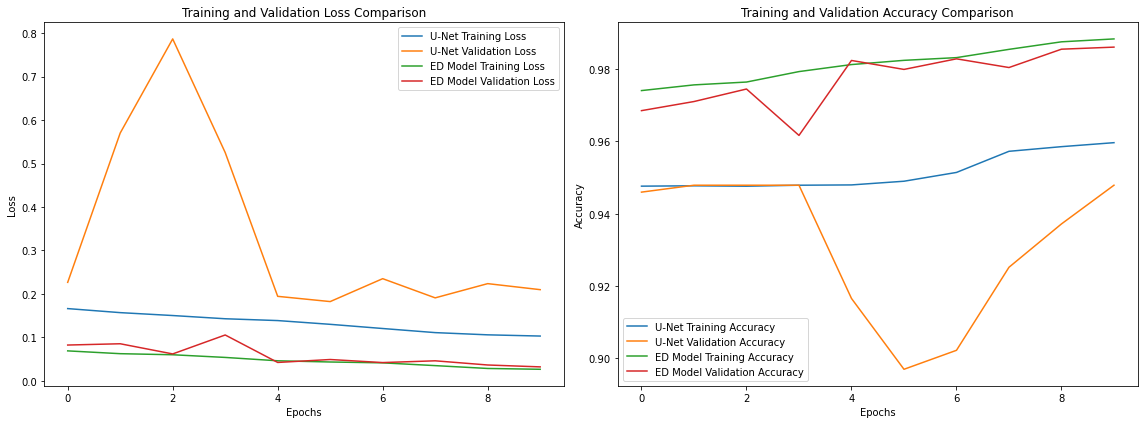

In [84]:
# 손실 값과 정확도를 함께 시각화
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 왼쪽: Loss 그래프
axes[0].plot(history_unet.history['loss'], label='U-Net Training Loss')
axes[0].plot(history_unet.history['val_loss'], label='U-Net Validation Loss')
axes[0].plot(history_ed.history['loss'], label='ED Model Training Loss')
axes[0].plot(history_ed.history['val_loss'], label='ED Model Validation Loss')
axes[0].set_title('Training and Validation Loss Comparison')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()

# 오른쪽: Accuracy 그래프
axes[1].plot(history_unet.history['accuracy'], label='U-Net Training Accuracy')
axes[1].plot(history_unet.history['val_accuracy'], label='U-Net Validation Accuracy')
axes[1].plot(history_ed.history['accuracy'], label='ED Model Training Accuracy')
axes[1].plot(history_ed.history['val_accuracy'], label='ED Model Validation Accuracy')
axes[1].set_title('Training and Validation Accuracy Comparison')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()


# STEP 5 : 회고

#### U-Net 모델 성능
MeanIoU: [0.2155, 0.9493]
초반에 비해 최종 값이 크게 향상되었음. 훈련이 잘 진행된 결과로 보이고, 세그멘테이션에서 아주 좋은 성능을 보임
Accuracy: 0.1030 -> 0.9493
Accuracy가 처음에 낮았으나, 훈련을 거치면서 많이 향상됨. 배경 클래스에 대한 예측은 잘했을 것으로 예상됨. 하지만 Accuracy만 보면 실제 객체 예측 성능은 정확하게 알기 어려움. 이 점은 IoU나 Dice coefficient로 보완할 필요가 있음.



#### ED 모델 성능
MeanIoU: [0.2192, 0.9518]
MeanIoU 값도 U-Net과 비슷하게 0.95 이상으로 매우 우수. 이 모델도 세그멘테이션 성능이 높게 나옴
Accuracy: 0.0266 -> 0.9883
Accuracy도 급격히 향상되었음. 훈련이 잘 되어가는 느낌. 배경 클래스 예측이 잘 되면서 Accuracy가 높아졌을 것. 마찬가지로, IoU나 Dice coefficient와 같은 지표를 추가로 확인할 필요



#### 회고
성능 향상:
U-Net과 ED 모델 모두 매우 좋은 성능을 보여주고 있음. 최종적으로 MeanIoU가 0.95에 가까운 값으로 안정화되었고, 이는 분할 작업에서 좋은 성능을 나타냄. 두 모델 모두 잘 학습됨


#### Accuracy:
Accuracy가 높지만, 이 값은 모델이 배경(0) 클래스를 잘 예측했기 때문에 높은 점수를 받은 것일 가능성이 있음. 따라서 객체(1) 클래스 예측 성능을 평가하는 지표를 사용하는 게 중요.


#### 과적합:
Accuracy와 loss가 모두 안정적이고 좋아진 것을 보면, 모델이 과적합되지 않고 잘 일반화된 것 같음. 하지만 과적합을 완전히 막기 위해서는 Early Stopping이나 Regularization 등을 고려해볼 필요가 있음


#### 향후 개선점:
객체와 배경의 불균형 문제를 해결하기 위해 class weights를 적용하는 것도 좋은 방법이 될 것 같음. 배경 클래스가 상대적으로 많아서 모델이 배경에 치우쳐질 가능성도 있음. 
시간이 부족해 3가지 모델을 다 하지 못하고 2가지 모델밖에 완수하지 못함. (건강 이슈입니다...)


#### 지표 보강:
Accuracy 외에도 IoU, Dice coefficient, F1-score와 같은 지표를 사용하면 성능을 좀 더 세밀하게 평가할 수 있을 것 같음. 이 부분에서 좀 더 개선된 분석을 했어야 했는데 아쉬움

느낀 점: 
의료 영상 처리와 U-Net 모델을 활용한 세그멘테이션 작업을 진행하면서 많은 것을 배울 수 있었음. 특히, 데이터 전처리와 augmentation을 적절히 적용하는 것이 얼마나 중요한지 실감하였다. 
전처리 및 augmentation 과정에서 각종 방법을 실험해볼 수 있었음. 